## Introduction

In this project, we analyze the sales data of the products of the last few years of a company that is an exporter to different countries. This project includes the following 5 steps:

<ol>
<li>Data preprocessing</li>
<li>Exploration</li>
<li>Study of target markets</li>
<li>Customer evaluation (using rfm analysis)</li>
<li>Customer retention analysis</li>
</ol>

The data explanations are as follows:

| Column Name | Column Description       
| :- |:-
|InvoiceNumber | A 6-digit number that is uniquely assigned to each invoice. If the beginning of this number starts with the letter C, it means that the invoice has been canceled.
|ProductCode | A 5-digit number that is uniquely assigned to each type of product.
|ProductName | Product Name
|Quantity | Number of orders of a product type in the invoice
|InvoiceDate | Invoice creation date
|UnitPrice | The unit price of a product
|CusotmerId | A 5-digit number which is uniquely assigned to each customer.
|Country | Name of the customer's country of residence

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
sales_df = pd.read_excel("sales.xlsx", parse_dates=[4])
sales_df.head()

,InvoiceNumber,ProductCode,ProductName,Quantity,InvoiceDate,UnitPrice,CustomerId,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# remove null customer id values
df_no_missing_CustomerId = sales_df.dropna(subset=['CustomerId'])

In [4]:
# keep only one row per duplicate rows
df_no_duplicate = df_no_missing_CustomerId.drop_duplicates()

In [5]:
# remove prices not bigger than zero
df_no_missing_price = df_no_duplicate[ df_no_duplicate.UnitPrice > 0 ].copy()

## Exploration

#### Percentage of canceled orders:
Because an order may contain more than one product, some order IDs are repeated multiple times. To calculate the percentage of canceled orders, we must consider each order only once.

In [6]:
# calculate the percentage of cancelled orderes

df_no_missing_price['is_canceled'] = df_no_missing_price.InvoiceNumber.str.startswith('C', na=False)

percentage_cancelled_orders = round(100 *\
                    df_no_missing_price [df_no_missing_price.is_canceled==True].InvoiceNumber.nunique()/\
                    df_no_missing_price.InvoiceNumber.nunique())
print("percent of cancelled orders is almost {}%".format(percentage_cancelled_orders))

percent of cancelled orders is almost 19%


#### ID of 5 customers with the most canceled orders:

In [7]:
# change customer id to string
df_no_missing_price.CustomerId = df_no_missing_price.CustomerId.astype('int')
df_no_missing_price.CustomerId = df_no_missing_price.CustomerId.astype('str')

# calculate the top 5 cancelling customers
group = df_no_missing_price.groupby('CustomerId').is_canceled.sum().reset_index()\
        .sort_values(by='is_canceled', ascending=False)
group.head()

,CustomerId,is_canceled
2163,15311,171
1867,14911,139
3805,17511,110
1688,14680,103
1039,13798,102


In [8]:
top_cancelling_customers = ['15311', '14911', '17511', '14680', '13798']

Finally, we remove the rows related to canceled orders.

In [9]:
# remove the cancelled orderes
df = df_no_missing_price[df_no_missing_price.is_canceled==False].copy()

In [10]:
df.drop(columns=['is_canceled'], inplace=True)

In [11]:
# calculate the number of remaining orders
number_of_orders = df.InvoiceNumber.nunique()
print("Number of orders :{}".format(number_of_orders))

Number of orders :19213


In [12]:
# calculate the time period window
window_period = (str(df.InvoiceDate.min()), str(df.InvoiceDate.max()))
print("Orders was place from {} to {}".format(window_period[0],window_period[1]))

Orders was place from 2009-12-01 07:45:00 to 2010-12-09 20:01:00


#### Number of invoices per week days:

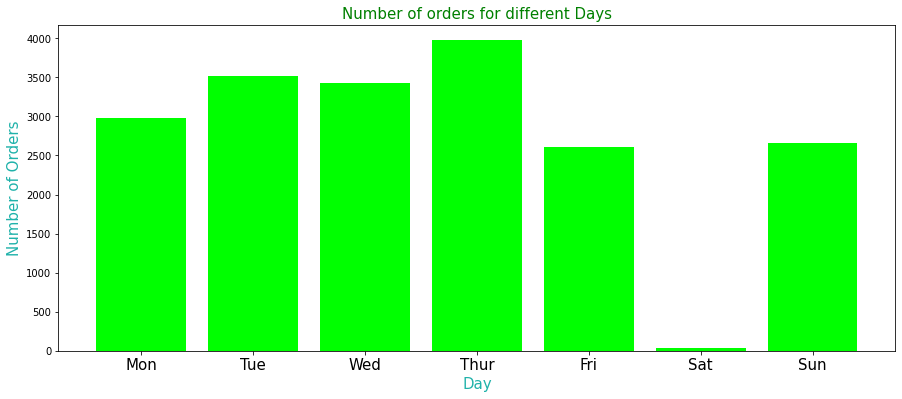

In [13]:
# plot the number of orders per week day

df['week_day'] = df.InvoiceDate.dt.weekday
week_day_group = df.groupby('week_day').InvoiceNumber.nunique().reset_index(name="order_counts")

fig1 , ax1 = plt.subplots(figsize=(15, 6))
labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

ax1.bar(range(len(labels)), week_day_group.order_counts, color = 'lime')

ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, fontsize=15)

ax1.set_xlabel('Day', color='lightseagreen', fontsize=15)
ax1.set_ylabel('Number of Orders', color='lightseagreen', fontsize=15)
ax1.set_title('Number of orders for different Days', fontsize=15, color='green');

#### Total sales per month:

We plot the total sales per month in a bar chart. First, we need to calculate the total cost received for each invoice.

In [14]:
import datetime

def get_month_year(arr):
    return arr.strftime("%b") + "_" + str(arr.year)

df['price'] = df.Quantity * df.UnitPrice

df["month_year"] = df.InvoiceDate.apply(get_month_year)
month_year_group = df.groupby("month_year").price.sum().reset_index()
month_year_group.head()

,month_year,price
0,Apr_2010,591982.002
1,Aug_2010,602224.600
2,Dec_2009,683504.010
3,Dec_2010,310656.370
4,Feb_2010,504558.956


In [15]:
month_year_group['year'] = month_year_group['month_year'].str.split("_", expand=True)[1].astype(int)
month_year_group['month'] = month_year_group['month_year'].str.split("_", expand=True)[0]

month_year_group['month'] = month_year_group['month'].apply(lambda x:  datetime.datetime.strptime(x, "%b").month)
month_year_group.sort_values(['year', 'month'], inplace=True)
month_year_group.head()

,month_year,price,year,month
2,Dec_2009,683504.010,2009,12
5,Jan_2010,555802.672,2010,1
4,Feb_2010,504558.956,2010,2
8,Mar_2010,696978.471,2010,3
0,Apr_2010,591982.002,2010,4


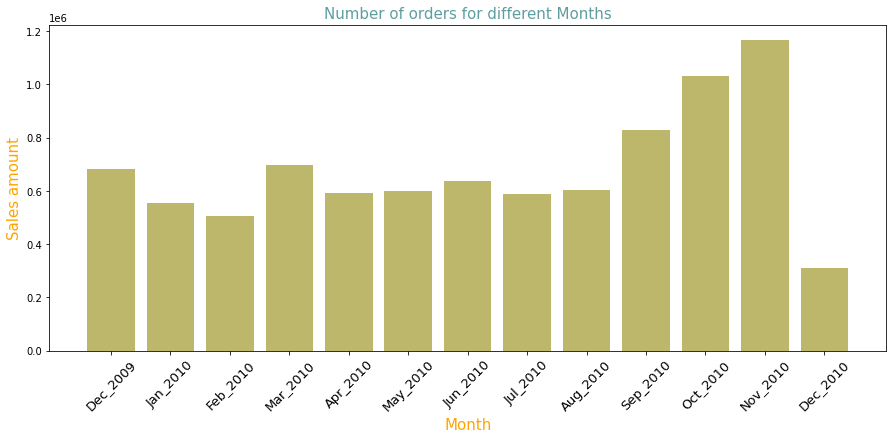

In [16]:
fig2 , ax2 = plt.subplots(figsize=(15, 6))
ax2.bar(month_year_group.month_year, month_year_group.price, color="darkkhaki")
ax2.set_xticks(range(month_year_group.month_year.nunique()))
labels = month_year_group.month_year.unique().tolist()

ax2.set_xticklabels(labels, rotation=45, fontsize=13)
ax2.set_xlabel("Month", color = "orange", fontsize=15)
ax2.set_ylabel("Sales amount", color = "orange", fontsize=15)
ax2.set_title("Number of orders for different Months", color = "cadetblue", fontsize=15);

## Study of target markets

#### Scatter plot of sales and number of customers in each country:

In this section, we show different countries on a scatter plot to see their sales and number of customers. As shown below, countries are divided into four groups according to sales amount and number of customers.<br/>
Using the third quarter of both criteria, we are faced with 4 groups of countries. If we show the sales amount as SA and the third quarter as qSA, the number of customers as CC and the third quarter with qCC, the four groups of countries are defined as follows:

<ol>
    <li>Countries where SA &lt; qSA and CC &lt; qCC </li>
    <li>Countries where SA &lt; qSA and CC > qCC </li>
    <li>Countries where SA > qSA and CC &lt; qCC </li>
    <li>Countries where SA > qSA and CC > qCC </li>
</ol>

To plot, we do the following steps:
<ul>
    <li>First we delete orders related to United Kingdom </li>
    <li>For each country, we calculate the number of customers and the amount of sales. </li>
    <li>We calculate the third quarter of sales and number of customers. </li>
    <li>Using the above description, we divide the countries into four groups. </li>
</ul>

Finally, we show 4 countries of France, Spain and the Netherlands on the map.

In [17]:
# prepare the dataframe

df = df.drop( df[df.Country == "United Kingdom"].index )
df['price'] = df.Quantity * df.UnitPrice
country_sale_amount = df.groupby("Country").price.sum().reset_index(name = 'SA')
country_sale_count = df.groupby("Country").CustomerId.nunique().reset_index(name = 'CC')
country_df = country_sale_amount.merge(country_sale_count)

qSA = np.quantile(country_sale_amount.SA, 0.75)
qCC = np.quantile(country_sale_count.CC, 0.75)

group1 = country_df[ (country_df.SA < qSA) & (country_df.CC < qCC)]
group2 = country_df[ (country_df.SA < qSA) & (country_df.CC > qCC)]
group3 = country_df[ (country_df.SA > qSA) & (country_df.CC < qCC)]
group4 = country_df[ (country_df.SA > qSA) & (country_df.CC > qCC)]

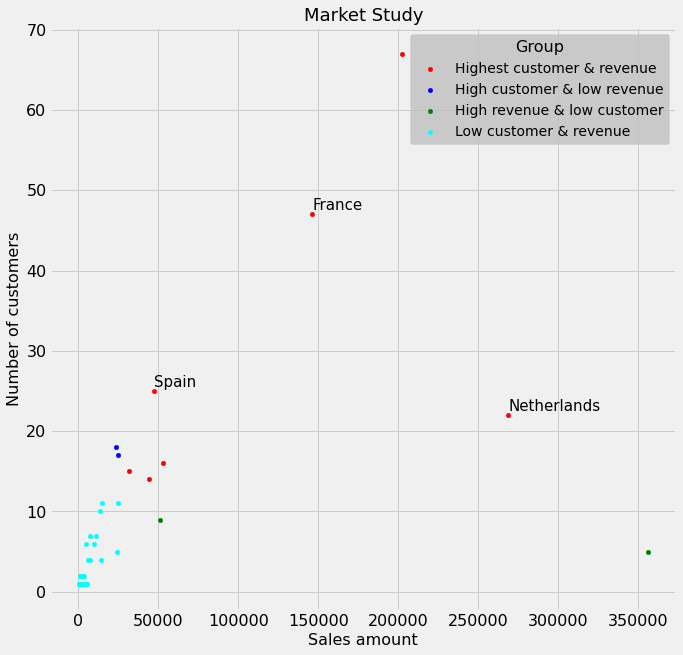

In [18]:
# plot

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(group4.SA, group4.CC, color = 'red', s=20, label = "Highest customer & revenue")
plt.scatter(group2.SA, group2.CC, color = 'blue', s=20, label = "High customer & low revenue")
plt.scatter(group3.SA, group3.CC, color = 'green', s=20, label = "High revenue & low customer")
plt.scatter(group1.SA, group1.CC, color = 'cyan', s=20, label = "Low customer & revenue")
ax.set_xlabel('Sales amount', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

ax.set_ylabel('Number of customers', fontsize = 16)
ax.set_title('Market Study', fontsize = 18)

plt.legend(title = "Group", frameon=True, title_fontsize = 16, fontsize = 14 ,facecolor = 'silver'  )

Netherlands_x, Netherlands_y = country_df[country_df.Country == "Netherlands"].SA , country_df[country_df.Country == "Netherlands"].CC + 0.5
France_x, France_y = country_df[country_df.Country == "France"].SA , country_df[country_df.Country == "France"].CC + 0.5
Spain_x, Spain_y = country_df[country_df.Country == "Spain"].SA , country_df[country_df.Country == "Spain"].CC + 0.5

ax.text(Netherlands_x, Netherlands_y, "Netherlands", fontsize = 15 )
ax.text(France_x, France_y, "France",fontsize = 15 )
ax.text(Spain_x, Spain_y , "Spain", fontsize = 15);

## Customers Valuation 

We use a famous method of customer behavior analysis called RFM to group our customers based on their value to the company. According to this method, the following three criteria are considered for each customer:

<ul>
    <li>Recency : The number of days that passed since the last purchase of the customer.</li>
    <li>Frequency : The number of times a customer has purchased from us.</li>
    <li>Monetary : The total income the company has from a customer.</li>
</ul>

These criteria represent important indicators in customer behavior. For example, the newer the purchase, the more likely the customer is to buy again. The more times a customer buys, the more satisfied the customer is, and the amount of revenue a customer generates for a company can differentiate him or her from other buyers.<br/>

First, we calculate these three criteria for each customer. To calculate Recency, we count the number of days before one day after the last day in the data (assuming we are doing this step on that day).<br/>


After calculating these three criteria, the value of each criterion is divided into 4 groups based on the first, second and third quarters as follows:

<br/>

<div>
    <ul>
        <li><b>Group1</b>: value <= Q1</li>
        <li><b>Group2</b>: Q1 &lt; value <= Q2</li>
        <li><b>Group3</b>: Q2 &lt; value <= Q3</li>
        <li><b>Group4</b>: Q3 &lt; value</li>
    </ul>
</div>

<br/>
Using these three criteria, the value of each customer (RFM criterion) is calculated by putting together the Recency-Frequency-Monetary value groups.

| CustomerID | Recency | Frequency | Monetary value| R_quartile      | F_quartile      | M_quartile      | RFM    |
| ---------- | ------- | --------- | -------- | ------ | ------ | ------ | ------ |
| 12346      | 325     | 1         | 77183.60 | 1      | 1      | 4      | 114    |
| 12347      | 2       | 182       | 4310.00  | 4      | 4      | 4      | 444    |
| 12348      | 75      | 31        | 1797.24  | 2      | 2      | 4      | 224    |

For example, a customer with ID 12346 had a Recency of 325. The number 325 was less than or equal to the first quarter of the Recents. Therefore, for the Recency of this customer, we consider the number 1. For the other two values (Frequency and Monetary value) we follow the above to get their group. Now we put the group numbers of all three criteria together to create the RFM criterion. Now, we can group each customer according to the table below based on the RFM value.

| Segment | RFM |
|:-------------:|:------|
| Best | 144 |
| AlmostLost | 344 |  
| LostBigSpenders | 444  | 
| LostCheap | 441 |
| Loyal | X4X | 
| BigSpenders | XX4 | 

A value of X means any valid value. For example, 14X includes groups 141, 142, 143, 144. Also, if an RFM can be placed in two groups of the table, priority is given to the group that is listed first (above) in the table. If a customer is not in any of the groups in the table, we declare his group Normal. So for each customer, the marketing team can adopt a strategy tailored to the group they belong to. 

#### Calculating Frequency, Recency and Monetary value for each customer: 

In [19]:
from datetime import datetime

from_now = df.InvoiceDate.max()

df_recenecy = df.groupby("CustomerId").InvoiceDate.max().reset_index(name = 'last_purchase')
df_recenecy['recency'] = (from_now - df_recenecy.last_purchase).dt.days 
r1, r2, r3 = np.quantile(df_recenecy.recency, [0.25, 0.5, 0.75])

def get_recency_quantile(arr):
    if arr <= r1:
        return 1
    elif arr <= r2:
        return 2
    elif arr <= r3:
        return 3
    else:
        return 4
    
df_recenecy['R_quartile'] = df_recenecy.recency.apply(get_recency_quantile)
df_recenecy.head(3)

,CustomerId,last_purchase,recency,R_quartile
0,12347,2010-12-07 14:57:00,1,1
1,12348,2010-09-27 14:59:00,72,3
2,12349,2010-10-28 08:23:00,42,2


In [20]:
df_freq = df.groupby("CustomerId").InvoiceNumber.nunique().reset_index(name = 'frequency')
f1, f2, f3 = np.quantile(df_freq.frequency, [0.25, 0.5, 0.75])

def get_frequency_quantile(arr):
    if arr <= f1:
        return 1
    elif arr <= f2:
        return 2
    elif arr <= f3:
        return 3
    else:
        return 4
    
df_freq['F_quartile'] = df_freq.frequency.apply(get_frequency_quantile)
df_freq.head(3)

,CustomerId,frequency,F_quartile
0,12347,2,2
1,12348,1,1
2,12349,3,3


In [21]:
df['price'] = df['Quantity'] * df['UnitPrice']

df_monetary = df.groupby("CustomerId").price.sum().reset_index(name = 'monetary')
m1, m2, m3 = np.quantile(df_monetary.monetary, [0.25, 0.5, 0.75])

def get_monetary_quantile(arr):
    if arr <= m1:
        return 1
    elif arr <= m2:
        return 2
    elif arr <= m3:
        return 3
    else:
        return 4
    
df_monetary['M_quartile'] = df_monetary.monetary.apply(get_monetary_quantile)
df_monetary.head(3)

,CustomerId,monetary,M_quartile
0,12347,1323.32,3
1,12348,222.16,1
2,12349,2671.14,4


In [22]:
df_all = df_recenecy.merge(df_freq).merge(df_monetary)
df_all['RFM'] = df_all['R_quartile']*100 + df_all['F_quartile']*10 + df_all['M_quartile']
df_all['RFM'] = df_all['RFM'].astype('str')
df_all.head(3)

,CustomerId,last_purchase,recency,R_quartile,frequency,F_quartile,monetary,M_quartile,RFM
0,12347,2010-12-07 14:57:00,1,1,2,2,1323.32,3,123
1,12348,2010-09-27 14:59:00,72,3,1,1,222.16,1,311
2,12349,2010-10-28 08:23:00,42,2,3,3,2671.14,4,234


In [23]:
def get_segment(arr):
    segment = 'Normal'
    if arr[2]=='4':
        segment = 'BigSpenders'
    if arr[1]=='4':
        segment = 'Loyal'
    if arr == '441':
        segment = 'LostCheap'
    if arr == '444':
        segment = 'LostBigSpenders'
    if arr == '344':
        segment = 'AlmostLost'
    if arr == '144':
        segment = 'Best'
    return segment
    
df_all['Segment'] = df_all.RFM.apply(get_segment)
df_customer_segments = df_all[['CustomerId', 'Segment']]
df_customer_segments

,CustomerId,Segment
0,12347,Normal
1,12348,Normal
2,12349,BigSpenders
3,12351,Normal
4,12352,Normal
...,...,...
339,17097,Normal
340,17404,Loyal
341,17508,Best
342,17829,BigSpenders


## Customer Retention Analysis

To attract a new customer to the company, the marketing team needs to use different methods of advertisement and communication with customers, which is costly. As a result, they are more willing to retain their current customers as much as possible.

We plot a customer retention chart. In this chart, the vertical axis indicates the month that a customer first traded with the company, and the horizontal axis shows what percentage of new customers remain a customer in the months following the first transaction.


As we can see, in the first month, a number of new customers had their first transaction with the company, of which 37.3% of them traded with the company at least once in the next month and in the next two month 41.2% of them had at least one factor.

In [24]:
# Step 1: Month Extraction from InvoiceDate Column

from datetime import datetime

def extract_month(date_value):
    return datetime(date_value.year, date_value.month, 1)

df['InvoiceMonth'] = df['InvoiceDate'].apply(extract_month) 
df[['InvoiceDate','InvoiceMonth']].head()

,InvoiceDate,InvoiceMonth
71,2009-12-01 09:28:00,2009-12-01
72,2009-12-01 09:28:00,2009-12-01
73,2009-12-01 09:28:00,2009-12-01
74,2009-12-01 09:28:00,2009-12-01
75,2009-12-01 09:28:00,2009-12-01


In [25]:
df['CohortMonth'] = df.groupby('CustomerId')['InvoiceMonth'].transform('min')

df[['CustomerId','InvoiceDate','InvoiceMonth', 'CohortMonth']].head()

,CustomerId,InvoiceDate,InvoiceMonth,CohortMonth
71,12682,2009-12-01 09:28:00,2009-12-01,2009-12-01
72,12682,2009-12-01 09:28:00,2009-12-01,2009-12-01
73,12682,2009-12-01 09:28:00,2009-12-01,2009-12-01
74,12682,2009-12-01 09:28:00,2009-12-01,2009-12-01
75,12682,2009-12-01 09:28:00,2009-12-01,2009-12-01


In [26]:
# Step 3: Assigning Cohort Index to each transaction
# (In order to find Cohort index we have to find difference between
# InvoiceMonth & CohortMonth column in terms of number of months)

def parse_dates_int(date_column):
    year = date_column.dt.year
    month = date_column.dt.month
    return year, month

invoice_year, invoice_month = parse_dates_int(df['InvoiceDate'])

cohort_year, cohort_month = parse_dates_int(df['CohortMonth'])

In [27]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Using the variables created above to calcualte the difference in months and storing them in cohort Index column
df['CohortIndex'] = years_diff * 12 + months_diff + 1

In [28]:
df[['CustomerId','InvoiceDate','InvoiceMonth', 'CohortMonth', 'CohortIndex']].head()

,CustomerId,InvoiceDate,InvoiceMonth,CohortMonth,CohortIndex
71,12682,2009-12-01 09:28:00,2009-12-01,2009-12-01,1
72,12682,2009-12-01 09:28:00,2009-12-01,2009-12-01,1
73,12682,2009-12-01 09:28:00,2009-12-01,2009-12-01,1
74,12682,2009-12-01 09:28:00,2009-12-01,2009-12-01,1
75,12682,2009-12-01 09:28:00,2009-12-01,2009-12-01,1


In [29]:
# Step 4: Calculating number of unique customers in each Group of (CohortDate,Index)
cohort_data = df.groupby(['CohortMonth', 'CohortIndex']).CustomerId.nunique().reset_index(name = 'Count of unique CustomerID')
cohort_data.head()

,CohortMonth,CohortIndex,Count of unique CustomerID
0,2009-12-01,1,51
1,2009-12-01,2,19
2,2009-12-01,3,21
3,2009-12-01,4,24
4,2009-12-01,5,21


In [30]:
# Step 5: Retention rate Calculation

# Creating new dataframe with index as CohortMonth, columns as Cohort indexes and Values as Count
retention_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Count of unique CustomerID')
retention_counts.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2009-12-01,51.0,19.0,21.0,24.0,21.0,20.0,24.0,16.0,17.0,26.0,24.0,27.0,14.0
2010-01-01,38.0,7.0,9.0,9.0,10.0,5.0,12.0,7.0,12.0,10.0,10.0,3.0,NaN
2010-02-01,31.0,9.0,8.0,5.0,9.0,4.0,9.0,9.0,7.0,9.0,2.0,NaN,NaN
2010-03-01,31.0,3.0,4.0,5.0,6.0,3.0,5.0,8.0,6.0,1.0,NaN,NaN,NaN
2010-04-01,25.0,5.0,2.0,3.0,3.0,7.0,7.0,7.0,3.0,NaN,NaN,NaN,NaN


In [31]:
# Select the first column and store it to cohort_sizes
cohort_sizes = retention_counts.iloc[:,0]

In [32]:
# Divide the cohort count by cohort sizes along the rows
retention_rate = retention_counts.divide(cohort_sizes, axis=0)

# Coverting the retention rate into percentage and Rounding off.
retention_rate

# printing top 5 rows of retention Rate
retention_rate.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2009-12-01,100.0,37.3,41.2,47.1,41.2,39.2,47.1,31.4,33.3,51.0,47.1,52.9,27.5
2010-01-01,100.0,18.4,23.7,23.7,26.3,13.2,31.6,18.4,31.6,26.3,26.3,7.9,NaN
2010-02-01,100.0,29.0,25.8,16.1,29.0,12.9,29.0,29.0,22.6,29.0,6.5,NaN,NaN
2010-03-01,100.0,9.7,12.9,16.1,19.4,9.7,16.1,25.8,19.4,3.2,NaN,NaN,NaN
2010-04-01,100.0,20.0,8.0,12.0,12.0,28.0,28.0,28.0,12.0,NaN,NaN,NaN,NaN
2010-05-01,100.0,19.0,14.3,14.3,14.3,28.6,9.5,9.5,NaN,NaN,NaN,NaN,NaN
2010-06-01,100.0,20.8,12.5,16.7,25.0,25.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,100.0,17.4,26.1,26.1,34.8,8.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,100.0,15.4,30.8,53.8,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### heatmap:

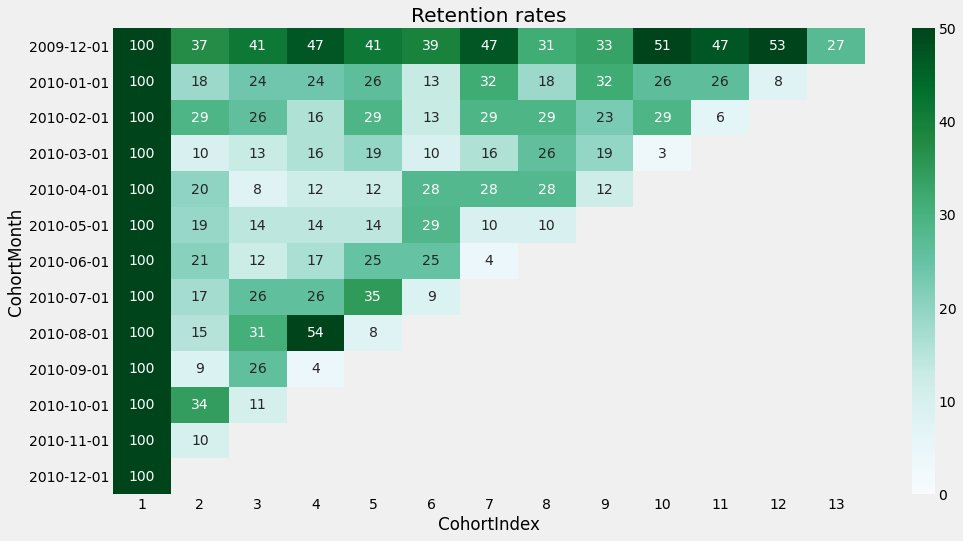

In [33]:
# Step 6: Visualizing the Above Retention rate

fig, ax = plt.subplots(figsize=(15, 8))
# my_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# my_mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(retention_rate*100, annot=True, fmt='0.0f', cmap="BuGn",  vmin = 0, vmax = 50,  ax=ax)
ax.set_title("Retention rates")
ax.set_yticklabels(retention_rate.index.date);